In [1]:
import csv, os, re, shutil,json, sys
import pandas as pd 
TCP = '/Users/amycweng/DH/TCP'
sys.path.append('../')

def findTextTCP(id):
    if re.match('B1|B4',id[0:2]):
        path = f'{TCP}/P2{id[0:2]}/{id}.P4.xml'
    else: 
        if f'{id}.P4.xml' in os.listdir(f'{TCP}/P1{id[0:2]}'):
            path = f'{TCP}/P1{id[0:2]}/{id}.P4.xml'
        elif f'{id}.P4.xml' in os.listdir(f'{TCP}/P2{id[0:2]}'): 
            path = f'{TCP}/P2{id[0:2]}/{id}.P4.xml'
    return path 

### Find texts that contain sermons (DIV tag with attribute "TYPE"='sermon' or containing key terms in the title or subject headings)

In [2]:
from bs4 import BeautifulSoup, SoupStrainer
def is_sermon(filepath):
    # read the input XML file 
    with open(filepath,'r') as file: 
        data = file.read()
    # use soupstrainer to only parse the main body
    tag = SoupStrainer("DIV1")
    soup = BeautifulSoup(data,features="xml",parse_only=tag)
    sermons = soup.findAll(attrs={"TYPE": "sermon"})
    if len(sermons) > 0:      
        return True
    return False

In [ ]:
metadataFolder = '/Users/amycweng/DH/ECBC-Data-2022/TCP metadata'
sermons = []
for csvFile in os.listdir(metadataFolder):
    data = pd.read_csv(os.path.join(metadataFolder,csvFile))
    for idx,tcpID in enumerate(data['id']):
        if tcpID == "id": continue
        filepath = findTextTCP(tcpID)
        if is_sermon(filepath): 
            subject_headings = data['keywords'][idx].replace(" -- ","; ").replace("  "," ")
            sermons.append( {"id": tcpID, 
                            "estc":data['estc'][idx],
                            "stc":data['stc'][idx],
                            "title": data['title'][idx],
                            "authors": "; ".join(set(data['author'][idx].split("; "))),
                            "publisher": data['publisher'][idx],
                            "pubplace":data['pubplace'][idx],
                            "subject_headings":subject_headings,
                            "date":data['date'][idx]
                            }
            )
    print(csvFile)

In [ ]:
# store relevant metadata in a CSV file 
with open("../assets/sermons.csv","w+") as outfile: 
    writer = csv.DictWriter(outfile, fieldnames=sermons[0].keys())
    writer.writeheader()
    writer.writerows(sermons)

print(f"{len(sermons)} TCP XML files contain sermons.") 

4239 TCP XML files contain sermons.


In [2]:
sermons_metadata = pd.read_csv("../assets/sermons.csv")
sermons = sermons_metadata["id"]

In [69]:
# Find the texts that most likely contain sermons but do not have the proper div tag in the XML 

import os 
import pandas as pd 
metadataFolder = '/Users/amycweng/DH/ECBC-Data-2022/TCP metadata'
texts = {}
by_subj, by_title, by_both = [],[],[]
for csvFile in os.listdir(metadataFolder):
    data = pd.read_csv(os.path.join(metadataFolder,csvFile))
    for idx,tcpID in enumerate(data['id']):
        title = data['title'][idx]
        clean_title = title.lower().replace("'",'')
        subject_headings = data['keywords'][idx]
        unique_subjects = " -- ".join(set(subject_headings.split(" -- ")))
        subject_hit, title_hit = False, False
        if re.search('sermon', subject_headings.lower()): 
            subject_hit = True 
        if re.search(r'sermon|preached|preacht|preachd', clean_title): 
            title_hit = True
        if subject_hit and title_hit: 
            by_both.append(tcpID)
        elif subject_hit: 
            by_subj.append(tcpID)
        elif title_hit: 
            by_title.append(tcpID)
        if subject_hit or title_hit:  
            texts[tcpID] =  {"id": tcpID, 
                            "estc":data['estc'][idx],
                            "stc":data['stc'][idx],
                            "title": data['title'][idx],
                            "authors": "; ".join(set(data['author'][idx].split("; "))),
                            "publisher": data['publisher'][idx],
                            "pubplace":data['pubplace'][idx],
                            "subject_headings":unique_subjects,
                            "date":data['date'][idx]
                            }
print(len(texts))

5839


In [10]:
new = []
sermons = {k:None for k in sermons}
import os 
import pandas as pd 
metadataFolder = '/Users/amycweng/DH/ECBC-Data-2022/TCP metadata'
for csvFile in os.listdir(metadataFolder):
    data = pd.read_csv(os.path.join(metadataFolder,csvFile))
    for idx,tcpID in enumerate(data['id']):
        if tcpID in sermons: 
            title = data['title'][idx]
            clean_title = title.lower().replace("'",'')
            subject_headings = data['keywords'][idx]
            unique_subjects = " -- ".join(set(subject_headings.split(" -- ")))  
            new.append({"id": tcpID, 
                        "estc":data['estc'][idx],
                        "stc":data['stc'][idx],
                        "title": data['title'][idx],
                        "authors": "; ".join(set(data['author'][idx].split("; "))),
                        "publisher": data['publisher'][idx],
                        "pubplace":data['pubplace'][idx],
                        "subject_headings":unique_subjects,
                        "date":data['date'][idx]
                        })
print(len(new))

4235


In [11]:
with open("../assets/sermons.csv","w+") as outfile: 
    writer = csv.DictWriter(outfile, fieldnames=new[0].keys())
    writer.writeheader()
    writer.writerows(new)

In [53]:
sermons = {tcpID:0 for tcpID in sermons}

In [70]:
missing_b, missing_s, missing_t = [],[],[]
missing = {0:[], 1:[], 2:[]}
for idx, collection in enumerate([by_both, by_subj, by_title]): 
    for tcpID in collection: 
        if tcpID not in sermons: missing[idx].append(tcpID)

In [71]:
print(len(missing[0]),len(missing[1]),len(missing[2]))

1081 313 393


In [56]:
exclude = ['B01388', 'A89416', 'B28836', 'B26622', 'B12473', 'B03839', 'B06138', 'B09463', 'A89104', 'A83012', 'A81906', 'A84063', 'A81606', 'A88596', 'A81417', 'A85341', 'A90702', 'A96864', 'A93332', 'A90476', 'A95939', 'A79568', 'A73832', 'A77100', 'A63877', 'A62992', 'A67411', 'A60864', 'A64639', 'A64197', 'A61683', 'A48191', 'A43685', 'A43806', 'A46883', 'A40538', 'A41496', 'A45149', 'A48968', 'A56791', 'A55289', 'A54939', 'A57258', 'A56278', 'A58892', 'A16497', 'A18267', 'A03696', 'A06013', 'A31039', 'A60568', 'A64394', 'A68546', 'A65419', 'A77638', 'A78013', 'A42577', 'A47973', 'A42539', 'A45574', 'A00164', 'A00156', 'A09418', 'A11848', 'A18019', 'A13299', 'A14927', 'A30903', 'A36190', 'A31459', 'A26859', 'A26426', 'A26065']

In [72]:
missing_texts = []
title_only = []
for idx, collection in missing.items(): 
    ''' 
    Exclude the missing TCP ids that only have key terms in the title but not the subject headings.
    These are the ones that are most likely to be false positives. 
    '''
    if idx == 2: 
        for tcpID in collection: 
            title_only.append(texts[tcpID]) 
    else: 
        for tcpID in collection: 
            if tcpID in exclude: continue
            missing_texts.append(texts[tcpID])
len(missing_texts), len(title_only)

(1359, 393)

In [ ]:
for t in texts.values(): 
    t = t["id"]
    path = findTextTCP(t)
    shutil.copy(path,'/Users/amycweng/DH/sermonsTCP')

In [73]:
unknown = []
for t in title_only: 
    tcpID = t["id"]
    title = t["title"]
    subjects = t["subject_headings"]
    if tcpID in sermons: continue
    if tcpID in exclude: 
        unknown.append(texts[tcpID])
        continue
    if re.search("answer|aunswer|ansvvere",title):
        if not re.search("substance of", title): 
            unknown.append(texts[tcpID])
        else: 
            missing_texts.append(texts[tcpID])
    elif re.search('sermon',title): 
        missing_texts.append(texts[tcpID])
    else: 
        unknown.append(texts[tcpID])

In [74]:
print(len(missing_texts), len(unknown))

1587 165


In [75]:
with open("../assets/sermons_missing.csv","w+") as outfile: 
    writer = csv.DictWriter(outfile, fieldnames=missing_texts[0].keys())
    writer.writeheader()
    writer.writerows(missing_texts)

In [76]:
with open("../assets/sermons_unknown.csv","w+") as outfile: 
    writer = csv.DictWriter(outfile, fieldnames=unknown[0].keys())
    writer.writeheader()
    writer.writerows(unknown)

Copy all the TCP XML files of the texts to a separate folder for easy browsing and extract plain text with proper delimiters  

In [33]:
from bs4 import BeautifulSoup, SoupStrainer
sermon_counts = {} # tcpID to a count 
def extract(tcpID, filepath):
    # read the input XML file 
    with open(filepath,'r') as file: 
        data = file.read()
    # use soupstrainer to only parse the main body
    tag = SoupStrainer("DIV1")
    soup = BeautifulSoup(data,features="xml",parse_only=tag)
    
    sermons = soup.findAll(attrs={"TYPE": ["sermon","text"]})
    if len(sermons) == 0: 
        sermons = soup.findAll(attrs={"TYPE": ["part"]})
        if len(sermons) == 0: 
            sermons = soup.findAll(attrs={"TYPE":["discourse","appendix", "funeral sermon","body of text","verse",
                                                "biblical commentary","treatise","tract","doctrine",
                                                "lecture", "book","conclusion","section","commentary","chapter",
                                                "panegyric","funeral speech","arguments","homily","colophon","polemic",
                                                "scaffold speech","speech","lamentation","essay","theological discourse",
                                                "memorial","consolatio","religious tract","oration and sermon","hymns",
                                                "vindication","scripture","criticism","observation","mock sermon"]})
            if len(sermons) == 0:
                sermons = soup.findAll(attrs={"TYPE":["sermons"]})  # no DIV2 
                if len(sermons) == 0:    
                    contents = soup.find_all(['DIV1'])
                    print(tcpID)
                    for c in contents: 
                        for attr in c.attrs.values(): 
                            print(attr)
                    return 0 
                
    sermon_text = []
    # need to place delimiters between each sermon, marginal note, and page
    p_idx = 0 
    for idx, sermon in enumerate(sermons):
        n_idx = 0 # note's relative position within sermon
        for t in sermon.find_all(['PB']):
            # page numbers 
            if t.name == "PB" and "N" in t.attrs: 
                page = t["N"]
                t.string = f' PAGE{page} '
            else: 
                page = t["REF"]
                t.string = f' PAGEIMAGE{page} '

        for t in sermon.find_all(['P']):
            # show display characters for GAP elements (illegible characters, non-Latin alphabet) 
            for gap in t.find_all("GAP"):
                if gap["DESC"] == "foreign": 
                    gap.string = " NONLATINALPHABET " # 〈 in non-Latin alphabet 〉
                elif "DISP" in gap.attrs: 
                    disp = gap["DISP"]
                    disp = re.sub("•","^",disp) # illegible letters 
                    disp = re.sub("◊","*",disp) # illegible words 
                    gap.string = disp
            for italics in t.find_all("HI"):
                italics.string = f" STARTITALICS {italics.text} ENDITALICS "
            for item in t.find_all(["NOTE"]):
                if item.name == "NOTE":
                    # add note delimiters 
                    item.string = f" STARTNOTE{n_idx} {item.text} ENDNOTE{n_idx} "
                    n_idx += 1 
            t.string = f" STARTPARAGRAPH{p_idx} {t.text} "
            p_idx += 1 
        text = re.sub(r"[^\x00-\x7F]","",str(sermon.text))
        text = re.sub(r"[\{\}\[\]]","",text)
        text = f"{f' SERMON{idx}'} {text}"
        text = re.sub(r"\s+"," ",text)
        sermon_text.append(text)
    with open(f"../assets/plain/{tcpID}.txt","w+") as file:
        file.writelines(" ".join(sermon_text)) # write as one long string          
    return len(sermons)

In [35]:
with open('../assets/corpora.json','r') as file: 
    corpora = json.load(file)
era = "pre-Elizabethan"
for prefix,tcpIDs in corpora[era].items():
    print(prefix)
    if len(tcpIDs) == 0: continue

    tcpIDs = sorted(tcpIDs)
    for tcpID in tcpIDs: 
        path = findTextTCP(tcpID)
        sermon_counts[tcpID] = extract(tcpID, path)

B
A0
A1
A2
A3
A4
A5
A6
A7
A8
A9


In [12]:
sermon_counts = {} # tcpID to a count of its sections labeled as sermons 
for t in texts.values(): 
    tcpID = t['id']
    path = findTextTCP(tcpID)
    sermon_counts[tcpID] = extract(tcpID, path)
    if len(sermon_counts) % 1000 == 0: print(f"Processed {len(sermon_counts)}")

B01388
response
A89416
title page
letter
B28836
letter
B26622
decree
B12473
title page
dedication
to the reader
subpoena
B03839
title page
Jacobite articles of faith
B06138
poem
letter
B09463
title page
to the reader
letter
A89104
title page
letter
response
A83012
title page
to the reader
letter
letter
postscript
dedication
letter
queries and counter-queries
errata
postscript
A81906
title page
license
imprimatur
letter
letter
A84063
title page
preface
letter
letter
letter
letter
letter
poem
A81606
title page
letter
postscript
A88596
title page
oration
A81417
title page
dialogue
A85341
title page
letter
A90702
title page
to the reader
A96864
title page
prologue
poems
A93332
imprimatur
title page
dedication
to the reader
answer
A90476
title page
newsbook
imprimatur
A95939
title page
introduction
to the reader
letter
Processed 1000
A79568
title page
letter
A73832
title page
dialogue
A77100
title page
list of academies
lat
to Oxbridge men
to the reader
1
query
2
query
3
query
4
query
errat

In [217]:
with open("../assets/DIV1_deviants.txt","r") as file:
    contents = file.read()
    exclude = {tcpID:0 for tcpID in re.findall(r"([A|B].*?)\n",contents)}
    print(exclude.keys())

dict_keys(['B01388', 'A89416', 'B28836', 'B26622', 'B12473', 'B03839', 'B06138', 'B09463', 'A89104', 'A83012', 'A81906', 'A84063', 'A81606', 'A88596', 'A81417', 'A85341', 'A90702', 'A96864', 'A93332', 'A90476', 'A95939', 'A79568', 'A73832', 'A77100', 'A63877', 'A62992', 'A67411', 'A60864', 'A64639', 'A64197', 'A61683', 'A48191', 'A43685', 'A43806', 'A46883', 'A40538', 'A41496', 'A45149', 'A48968', 'A56791', 'A55289', 'A54939', 'A57258', 'A56278', 'A58892', 'A16497', 'A18267', 'A03696', 'A06013', 'A31039', 'A60568', 'A64394', 'A68546', 'A65419', 'A77638', 'A78013', 'A42577', 'A47973', 'A42539', 'A45574', 'A00164', 'A00156', 'A09418', 'A11848', 'A18019', 'A13299', 'A14927', 'A30903', 'A36190', 'A31459', 'A26859', 'A26426', 'A26065'])


In [218]:
with open("../assets/sermon_counts.csv","w+") as outfile:
    json.dump(sermon_counts, outfile)

In [219]:
import matplotlib.pyplot as plt 
import numpy as np 
def visualize(x,y,title,xlabel,ylabel,color):
    plt.figure(figsize = (15, 10))
    plt.bar(x,y,color=color)
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=15)
    plt.xticks(np.arange(min(x), max(x)+1, 10.0), fontsize=12)
    plt.ylabel(ylabel, fontsize=15)
    plt.yticks(fontsize=10)
    plt.show()

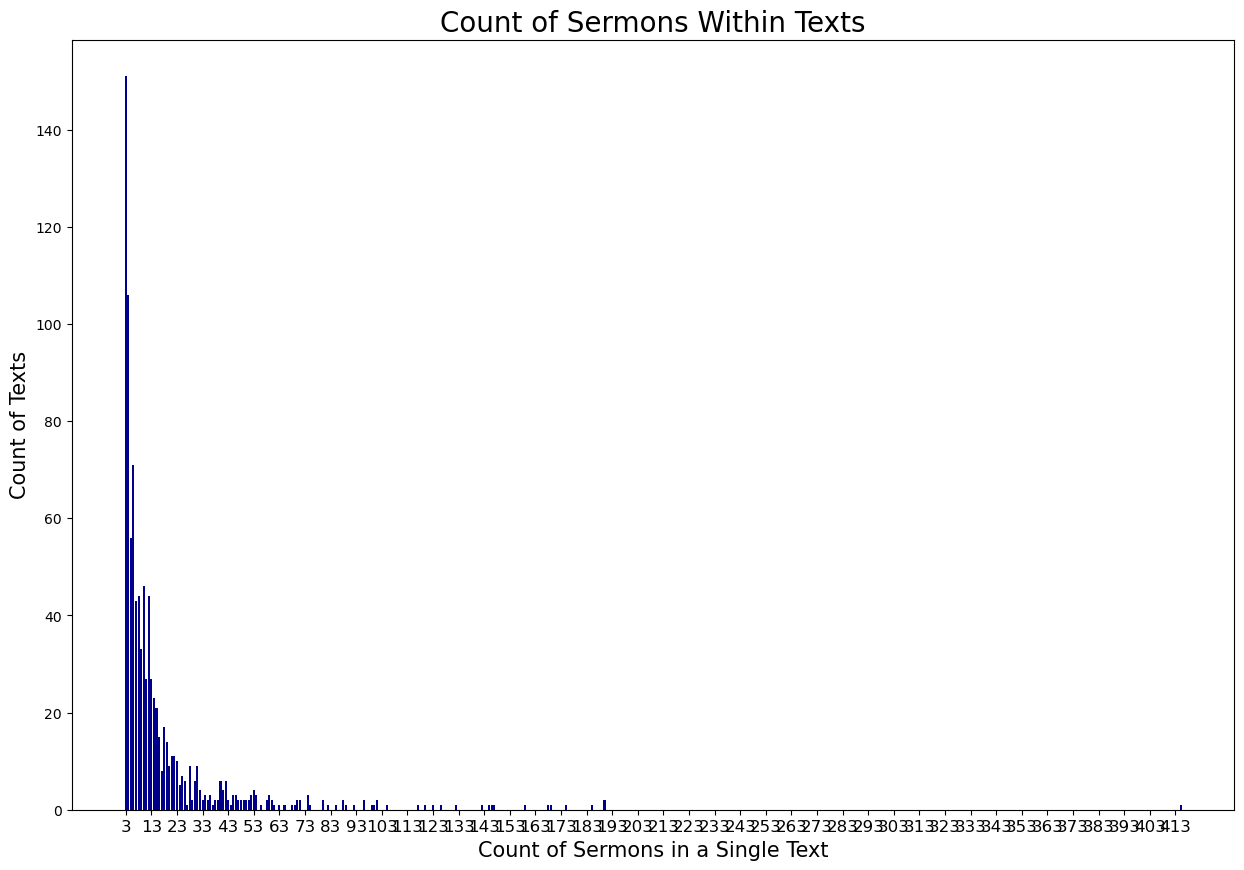

In [220]:
counts = {}
for s, count in sermon_counts.items(): 
    # if count < 3: continue
    if count not in counts: counts[count] = 0
    counts[count] += 1 
sorted_counts = {k:v for k,v in sorted(counts.items(),key=lambda k:k[1],reverse=True) if k > 2}
visualize(sorted_counts.keys(), sorted_counts.values(), 'Count of Sermons Within Texts','Count of Sermons in a Single Text','Count of Texts','darkblue')


In [221]:
print(sum(sermon_counts.values()))

21449


In [222]:
subjects = sermons_metadata["subject_headings"]
all_subjects = []
for s in subjects: 
    all_subjects.extend([_.strip('.') for _ in s.split("; ")])
from collections import Counter
print(Counter(all_subjects).most_common(n=20))


[('17th century', 3286), ('Sermons, English', 3246), ('Sermons', 3014), ('Bible', 1870), ('Early works to 1800', 1741), ('N.T', 935), ('O.T', 915), ('Funeral sermons', 461), ('Church of England', 322), ('Great Britain', 204), ('Fast-day sermons', 198), ('16th century', 195), ('History', 187), ('England', 158), ('Controversial literature', 104), ('Christian life', 99), ('Religious aspects', 78), ('Charles', 73), ('Commentaries', 63), ('Catholic Church', 63)]
